###  The code in this notebook can be used to replicate:
    1. Figure 4
    2. Extended Data Figures 5

######  Panels 4b, 4c, 4e and Extended Data Figure 5a, c, e are generated in https://github.com/SlavovLab/decode/tree/main/decode_analysis code


#### Decode pipeline output files (provided in https://drive.google.com/drive/folders/1fz9QbWfl5JxM6HdYedPqg4sc5_K4yx7j?usp=sharing or generated by rerunning pipeline https://github.com/SlavovLab/decode/tree/main/decode_pipeline) required: 

    1. "Supplemental_Data_2.SAAP_proteins.xlsx"
    2. "Supplemental_Data_3.SAAP_precursor_quant.xlsx"
    3. "Supplemental_Data_4.SAAP_reporter_quant.xlsx"  
    4. Other files in https://drive.google.com/drive/folders/15YoTBTZh4MdtAqHbibkYieEqyLyFi5hb?usp=sharing 


*** It is highly recommended to maintain the same directory structure as in the Google Drive ***


The code in this notebook is organized and labeled by references to figures in the manuscript.

In [3]:
# read in packages needed

import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from collections import Counter
import scipy as sp
from copy import deepcopy
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import os
import ast
from scipy.odr import Model, RealData, ODR
from scipy.stats import gaussian_kde
from matplotlib import gridspec
#import milkviz as mv
from matplotlib_venn import venn3
import zipfile
from glob import glob
import gzip
import tarfile
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator, FixedLocator
import statsmodels.api as sm
from statsmodels.formula.api import ols

#### Setting directories and reading in data.

All of these directories should be updated by the user to reflect where their output data from the decode pipeline st stored.


In [4]:
proj_dir = os.getcwd()+'/'
dependencies_dir = proj_dir+'pipeline_output/analysis_dependencies/'
outdir = 'figures_testing/' # output directory where to save figures

# [dataset]_aa_subs_dir is the decode pipeline output folder
ccrcc_proj_dir = dependencies_dir+'CCRCC/'
ccrcc_aa_subs_dir = ccrcc_proj_dir+'AA_subs_pipeline/'
ccrcc_sample_map = pd.read_excel(ccrcc_aa_subs_dir+'sample_map.xlsx')
ccrcc_samples = ['S'+str(i) for i in list(set(ccrcc_sample_map['TMT plex']))]

ucec_proj_dir = dependencies_dir+'UCEC/'
ucec_aa_subs_dir = ucec_proj_dir+'AA_subs_pipeline/'
ucec_sample_map = pd.read_excel(ucec_aa_subs_dir+'sample_map.xlsx')
ucec_samples = ['S'+str(i) for i in list(set(ucec_sample_map['TMT plex']))]

brca_proj_dir = dependencies_dir+'BRCA/'
brca_aa_subs_dir = brca_proj_dir+'AA_subs_pipeline/'
brca_sample_map = pd.read_excel(brca_aa_subs_dir+'sample_map.xlsx')
brca_samples = ['S'+str(i) for i in list(set(brca_sample_map['TMT plex']))]

luad_proj_dir = dependencies_dir+'LUAD/'
luad_aa_subs_dir = luad_proj_dir+'AA_subs_pipeline/'
luad_sample_map = pd.read_excel(luad_aa_subs_dir+'sample_map.xlsx')
luad_samples = ['S'+str(i) for i in list(set(luad_sample_map['TMT plex']))]

pdac_proj_dir = dependencies_dir+'PDAC/'
pdac_aa_subs_dir = pdac_proj_dir+'AA_subs_pipeline/'
pdac_sample_map = pd.read_excel(pdac_aa_subs_dir+'sample_map.xlsx')
pdac_samples = ['S'+str(i) for i in list(set(pdac_sample_map['TMT plex']))]

lscc_proj_dir = dependencies_dir+'LSCC/'
lscc_aa_subs_dir = lscc_proj_dir+'AA_subs_pipeline/'
lscc_sample_map = pd.read_excel(lscc_aa_subs_dir+'sample_map.xlsx')
lscc_samples = ['S'+str(i) for i in list(set(lscc_sample_map['TMT plex']))]

wang_proj_dir = dependencies_dir+'HealthyTissues/'
wang_data_dir = wang_proj_dir+'AA_subs_pipeline/'
wang_samples = open(wang_data_dir+'proteomic_tissue_list.txt', 'r').read().split('\n')
wang_samples = [x for x in wang_samples if x!='rectum']

# lists used to quickly index dataset-specific sample maps (e.g.) from just the dataset name
datasets = ['CCRCC', 'UCEC', 'BRCA', 'LUAD', 'PDAC', 'LSCC', 'Healthy']
data_dir_list = [ccrcc_aa_subs_dir, ucec_aa_subs_dir, brca_aa_subs_dir, luad_aa_subs_dir, pdac_aa_subs_dir, lscc_aa_subs_dir, wang_data_dir]
samples_list = [ccrcc_samples, ucec_samples, brca_samples, luad_samples, pdac_samples, lscc_samples, wang_samples]
sample_map_list = [ccrcc_sample_map, ucec_sample_map, brca_sample_map, luad_sample_map, pdac_sample_map, lscc_sample_map]
proj_dir_list = [ccrcc_proj_dir, ucec_proj_dir, brca_proj_dir, luad_proj_dir, pdac_proj_dir, lscc_proj_dir, wang_proj_dir]


In [5]:
class GridShader():
    """
    function used to create alternating vertical gray and white background in plots
    """
    def __init__(self, ax, first=True, **kwargs):
        self.spans = []
        self.sf = first
        self.ax = ax
        self.kw = kwargs
        self.ax.autoscale(False, axis="x")
        self.cid = self.ax.callbacks.connect('xlim_changed', self.shade)
        self.shade()
    def clear(self):
        for span in self.spans:
            try:
                span.remove()
            except:
                pass
    def shade(self, evt=None):
        self.clear()
        xticks = self.ax.get_xticks()
        xlim = self.ax.get_xlim()
        xticks = xticks[(xticks > xlim[0]) & (xticks < xlim[-1])]
        locs = np.concatenate(([[xlim[0]], xticks, [xlim[-1]]]))

        start = [x-0.5 for x in locs[1-int(self.sf)::2]]
        end = [x-0.5 for x in locs[2-int(self.sf)::2]]

        for s, e in zip(start, end):
            self.spans.append(self.ax.axvspan(s, e, zorder=0, **self.kw))


def bihist(y1, y2, nbins=10, h=None):
    '''
    Function used to create violin plots as bihistograms with no smoothing.
    h is an axis handle. If not present, a new figure is created.
    '''
    if h is None: h = plt.figure().add_subplot(111)
    ymin = np.floor(np.minimum(min(y1), min(y2)))
    ymax = np.ceil(np.maximum(max(y1), max(y2)))
    bins = np.linspace(ymin, ymax, nbins)
    n1, bins1, patch1 = h.hist(y1, bins, orientation='horizontal', color='#AAAAAA', edgecolor=None, linewidth=0,rwidth=1)
    n2, bins2, patch2 = h.hist(y2, bins, orientation='horizontal', color='#AAAAAA', edgecolor=None, linewidth=0,rwidth=1)
    # set xmax:
    xmax = 0
    for i in patch1:
        i.set_edgecolor(None)
        width = i.get_width()
        if width > xmax: xmax = width
    # invert second histogram and set xmin:
    xmin = 0
    for i in patch2:
        i.set_edgecolor(None)
        width = i.get_width()
        width = -width
        i.set_width(width)
        if width < xmin: xmin = width
    h.set_xlim(xmin*1.1, xmax*1.1)          
    h.figure.canvas.draw()

## Figure 4: Ratios by AAS

#### Incl. Extended Data Figure 5

In [6]:
filt_saap_df = pd.read_excel(dependencies_dir+'Supplemental_Data_2.SAAP_proteins.xlsx', index_col=0)
filt_prec_quant_df = pd.read_excel(dependencies_dir+'Supplemental_Data_3.SAAP_precursor_quant.xlsx', index_col=0)
filt_reporter_quant_df = pd.read_excel(dependencies_dir+'Supplemental_Data_4.SAAP_reporter_quant.xlsx', index_col=0)

In [7]:
# custom colormap
# this colormap is used for all RAAS dotplots 

import matplotlib
from matplotlib.cm import get_cmap
inferno_cmap = get_cmap('inferno')
viridis_cmap = get_cmap('viridis')

inferno_colors = inferno_cmap.colors
viridis_colors = viridis_cmap.colors

inferno_colors[-1] = viridis_colors[-1]
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", inferno_colors)

/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_81894/450589004.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  inferno_cmap = get_cmap('inferno')
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_81894/450589004.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis_cmap = get_cmap('viridis')


### Extended Data Figure 5b: Distributions of median RAAS for each substitution type

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


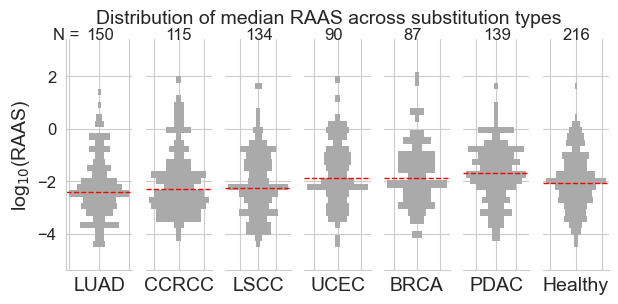

In [8]:
# list of all substitution types found in data
AASs = list(set(filt_prec_quant_df['AAS'].values))

# generate dictionary with RAAS values organized by substitution type
ratios_by_aas = {}
for i,ds in enumerate(datasets):
    print(ds)
    ds_prec_df = filt_prec_quant_df.loc[filt_prec_quant_df['Dataset']==ds]
    ds_report_df = filt_reporter_quant_df.loc[filt_reporter_quant_df['Dataset']==ds]
    aas_prec_ratio_df = ds_prec_df.loc[:, ['AAS', 'RAAS']]
    aas_prec_ratio_df.replace(np.inf, np.nan, inplace=True)
    aas_prec_ratio_df.replace(-np.inf, np.nan, inplace=True)
    aas_prec_ratio_df.dropna(how='any', axis=0, inplace=True)
    
    prec_subs_in_plot = [x for x in AASs if x in set(aas_prec_ratio_df['AAS'])]
    prec_medians = [np.nanmedian([x for x in aas_prec_ratio_df.loc[aas_prec_ratio_df['AAS']==sub,'RAAS'].values]) for sub in prec_subs_in_plot]
    prec_sorted_idx = np.argsort(prec_medians)
    prec_sorted_medians = [prec_medians[i] for i in prec_sorted_idx]
    prec_sorted_subs = [prec_subs_in_plot[i] for i in prec_sorted_idx]
    
    if ds !='Healthy':
        aas_ratio_df = ds_report_df.loc[:, ['AAS', 'RAAS']]
        aas_ratio_df.replace(np.inf, np.nan, inplace=True)
        aas_ratio_df.replace(-np.inf, np.nan, inplace=True)
        aas_ratio_df.dropna(how='any', axis=0, inplace=True)
        subs_in_plot = [x for x in AASs if x in set(aas_ratio_df['AAS'])]
        #medians = [np.nanmedian([x for x in aas_ratio_df.loc[aas_ratio_df['AAS']==sub,'Substitution ratio'].values]) for sub in subs_in_plot]
        medians = [np.nanmedian([x for x in aas_ratio_df.loc[aas_ratio_df['AAS']==sub,'RAAS'].values]) for sub in subs_in_plot]
        sorted_idx = np.argsort(medians)
        sorted_medians = [medians[i] for i in sorted_idx]
        sorted_subs = [subs_in_plot[i] for i in sorted_idx]
        ratios_by_aas[ds] = {'Precursor_ratio_df': aas_prec_ratio_df, 'prec_AAS_sorted':prec_sorted_subs, 'prec_medians_sorted':prec_sorted_medians, 
                             'Reporter_ratio_df': aas_ratio_df, 'AAS_sorted':sorted_subs, 'medians_sorted':sorted_medians}
    else:
        ratios_by_aas[ds] = {'Precursor_ratio_df': aas_prec_ratio_df, 'prec_AAS_sorted':prec_sorted_subs, 'prec_medians_sorted':prec_sorted_medians}
pickle.dump(ratios_by_aas, open(outdir+'Ratios_by_AAS.p', 'wb'))

# get median RAAS for each AAS type
median_aas_ratios = {ds:{} for ds in datasets}
for ds in datasets:
    ds_aas_df = ratios_by_aas[ds]['Precursor_ratio_df']
    aas = list(set(ds_aas_df['AAS'].values))
    aas_medians = {aa:np.median([x for x in ds_aas_df.loc[ds_aas_df['AAS']==aa,'RAAS'].values if ~np.isnan(x) and ~np.isinf(x)]) for aa in aas}
    median_aas_ratios[ds] = aas_medians


# plot distributions of median RAAS across AAS types
sns.set_style('whitegrid')
fig,axes = plt.subplots(1,len(datasets),figsize=(len(datasets),3), sharey=True)

for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params('x', bottom=False,labelbottom=False)
    if ax!=axes[0]:    
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)

# get medians of each dataset to sort datasets for visualization
medians = [np.nanmedian(list(median_aas_ratios[ds].values())) for ds in datasets if ds!='Healthy']
med_sort_idx = list(np.argsort(medians))
med_sort_idx.append(max(med_sort_idx)+1)

for i,ds in enumerate(datasets):
    ax_idx = med_sort_idx.index(i)
    axes[ax_idx].set_xlabel(ds, fontsize=14)
    ratio_data = list(median_aas_ratios[ds].values())
    bihist(ratio_data, ratio_data, nbins=30,h=axes[ax_idx])
    if ax_idx==0:
        axes[ax_idx].annotate('N = ', (-0.2,1), xycoords='axes fraction', fontsize=12)
    axes[ax_idx].annotate('{:,}'.format((len(ratio_data))), (0.3,1), xycoords='axes fraction', fontsize=12)
    axes[ax_idx].plot(axes[ax_idx].get_xlim(), (np.nanmedian(ratio_data), np.nanmedian(ratio_data)), '--r',linewidth=1)
axes[0].set_ylabel(r'log$_{10}$(RAAS)', fontsize=14)
axes[0].tick_params('y', labelsize=12)
plt.suptitle('Distribution of median RAAS across substitution types', fontsize=14)
plt.savefig(outdir+'MedianRAAS_byAAStype_hist.pdf', bbox_inches='tight')

### Figure 4d: weighted correlation of median RAAS for AAS types across datasets

In [ ]:
# code to get dictionary of RAAS values stratified by substitution type (e.g. base->substituted amino acid).
raas_by_aas_stats = {}

for ds in datasets:
    print(ds)
    raas_by_aas_stats[ds] = {}
    ratios_df = ratios_by_aas[ds]['Precursor_ratio_df']
    all_raas = ratios_df['RAAS'].values

    median_raas_dict = median_aas_ratios[ds]
    aas = sorted(list(median_raas_dict.keys()))
    medians = [median_raas_dict[aa] for aa in aas]
    sort_idx = np.argsort(medians)
    sort_aas = [aas[i] for i in sort_idx]

    for i,aa in enumerate(sort_aas):
        rank = i
        aas_raas = ratios_df.loc[ratios_df['AAS']==aa, 'RAAS'].values
        n = len(aas_raas)
        ttest_p = sp.stats.ttest_ind(aas_raas, all_raas, nan_policy='omit')[1]
        ranksums_p = sp.stats.ranksums(aas_raas, all_raas)[1]

        raas_by_aas_stats[ds][aa] = {'Median_raas':median_raas_dict[aa], 'Rank':rank, 'N_peptides':n, 
                                     'RAAS_vals':list(aas_raas), 'ttest_p':ttest_p, 'ranksum_p':ranksums_p}
    
    if ds!='Healthy':
        report_ratios_df = ratios_by_aas[ds]['Reporter_ratio_df']
        all_report_raas = ratios_df['RAAS'].values
        
        for i,aa in enumerate(sort_aas):
            aas_raas = report_ratios_df.loc[report_ratios_df['AAS']==aa, 'RAAS'].values
            n = len(aas_raas)
            ttest_p = sp.stats.ttest_ind(aas_raas, all_report_raas, nan_policy='omit')[1]
            ranksums_p = sp.stats.ranksums(aas_raas, all_raas)[1]


            raas_by_aas_stats[ds][aa]['Report_RAAS_vals'] = list(aas_raas)
            raas_by_aas_stats[ds][aa]['Report_ttest_p'] = ttest_p
            raas_by_aas_stats[ds][aa]['Report_ranksum_p'] = ranksums_p
            raas_by_aas_stats[ds][aa]['N_Reporter'] = n
            raas_by_aas_stats[ds][aa]['Reporter_median'] = np.nanmedian(aas_raas)

    
pickle.dump(raas_by_aas_stats, open(outdir+'RAAS_byAAS_stats.p', 'wb'))

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


In [10]:
def weighted_cov(x, y, w):
    """
    Calculates the weighted covariance between two vectors.

    Args:
      x (np.ndarray): First vector.
      y (np.ndarray): Second vector.
      w (np.ndarray): Weights vector (same length as x and y).

    Returns:
      float: Weighted covariance between x and y.
    """

    if len(x) != len(y) != len(w):
        raise ValueError("Input vectors and weights must have the same length.")
    mean_x = np.average(x, weights=w)
    mean_y = np.average(y, weights=w)
    cov = np.sum(w * (x - mean_x) * (y - mean_y))

    return cov


def weighted_corr(x, y, w):
    """
    Calculates the weighted Pearson correlation coefficient between two vectors.

    Args:
      x (np.ndarray): First vector.
      y (np.ndarray): Second vector.
      w (np.ndarray): Weights vector (same length as x and y).

    Returns:
      float: Weighted Pearson correlation coefficient between x and y.
    """
    cov = weighted_cov(x, y, w)
    std_x = np.sqrt(weighted_cov(x, x, w))
    std_y = np.sqrt(weighted_cov(y, y, w))
    if std_x * std_y == 0:
        return 0.0  # Avoid division by zero
    return(cov / (std_x * std_y))

In [14]:
ratios_by_aas['CCRCC'].keys()

dict_keys(['Precursor_ratio_df', 'prec_AAS_sorted', 'prec_medians_sorted', 'Reporter_ratio_df', 'AAS_sorted', 'medians_sorted'])

/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_81894/2571181074.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.ax_cbar.set_yticklabels([0,0.2,0.4,0.6,0.8, 1], fontsize=13)


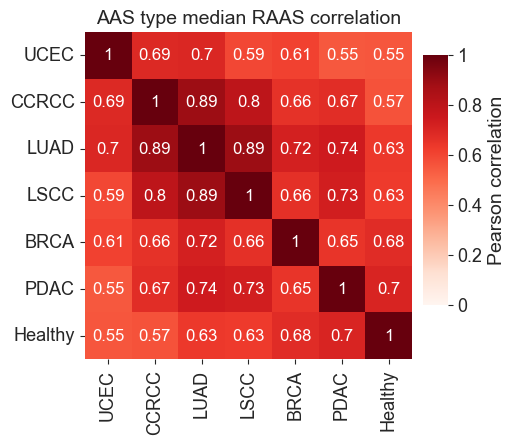

In [15]:
# generate a heatmap with the median precursor RAAS for each AAS type in each dataset 
prec_heatmap_data = pd.DataFrame(index=AASs, columns=datasets)
for i, row in prec_heatmap_data.iterrows():
    for ds in datasets:
        if ds=='Healthy':
            ds_ratios = ratios_by_aas[ds]
            medians = ds_ratios['prec_medians_sorted']
            aas = ds_ratios['prec_AAS_sorted']
            for i,aa in enumerate(aas):
                prec_heatmap_data.loc[aa,ds] = medians[i]
        else:
            ds_ratios = ratios_by_aas[ds]
            medians = ds_ratios['medians_sorted']
            aas = ds_ratios['AAS_sorted']
            for i,aa in enumerate(aas):
                prec_heatmap_data.loc[aa,ds] = medians[i]
prec_heatmap_data.dropna(how='all', inplace=True)
prec_heatmap_data.to_excel(outdir+'Precursor_RAAS_byAAS_alldatasets.xlsx')

# compute correlations of median RAAS by AAS vectors across datasets
prec_heatmap_data.replace(np.inf, np.nan, inplace=True)
heatmap_df_4corr = prec_heatmap_data.dropna(how='any')
corr_heatmap = pd.DataFrame(index=datasets, columns=datasets)
for ds1 in datasets:
    for ds2 in datasets:
        x = heatmap_df_4corr[ds1].to_list()
        y = heatmap_df_4corr[ds2].to_list()
        w = [raas_by_aas_stats[ds1][aas]['N_peptides']+raas_by_aas_stats[ds2][aas]['N_peptides'] for aas in heatmap_df_4corr.index]
        corr = weighted_corr(x, y, w)
        corr_heatmap.loc[ds1,ds2] = corr

# plot correlation heatmap
corr_heatmap = corr_heatmap.astype(float)
s= sns.clustermap(corr_heatmap, figsize=(5,5), annot=np.round(corr_heatmap, 2), cmap='Reds', cbar_kws={'label':'Pearson correlation', 'pad':1}, annot_kws={"fontsize":12},
                 vmax=1, vmin=0)

s.ax_heatmap.tick_params(right=False, left=True, labelright=False, labelleft=True, labelbottom=True, bottom=True)
plt.setp(s.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, fontsize=13)
plt.setp(s.ax_heatmap.yaxis.get_majorticklabels(), fontsize=13)
x0, y0, w, h = s.cbar_pos
s.ax_cbar.set_position([0.87,0.26,0.05,0.5])
s.ax_cbar.yaxis.label.set_size(14)
s.ax_cbar.set_yticklabels([0,0.2,0.4,0.6,0.8, 1], fontsize=13)
s.ax_row_dendrogram.set_visible(False)
s.ax_col_dendrogram.set_visible(False)
s.ax_heatmap.set_title('AAS type median RAAS correlation', position=(0.5,1), fontsize=14)
plt.savefig(outdir+'Correlation_heatmap_AAStype_PrecRatios_weighted_clustered_noNan.pdf', bbox_inches='tight')

### Extended Data Figure 5d,e: AAS types with high and low variance in RAAS across datasets

In [16]:
# generate a heatmap with the median reporter RAAS (precursor for healthy data) for each AAS type in each dataset 
heatmap_data = pd.DataFrame(index=AASs, columns=datasets)
for i, row in heatmap_data.iterrows():
    for ds in datasets:
        ds_ratios = ratios_by_aas[ds]
        if ds!='Healthy':
            medians = ds_ratios['medians_sorted']
            aas = ds_ratios['AAS_sorted']
        else:
            medians = ds_ratios['prec_medians_sorted']
            aas = ds_ratios['prec_AAS_sorted']
        for i,aa in enumerate(aas):
            heatmap_data.loc[aa,ds] = medians[i]
heatmap_df = heatmap_data.loc[:,['PDAC', 'BRCA', 'CCRCC', 'UCEC','LUAD', 'LSCC', 'Healthy']]
heatmap_df.dropna(how='any', axis=0, inplace=True)
heatmap_df = heatmap_df.astype(float)
heatmap_df.replace(np.inf, np.nan, inplace=True)
heatmap_data.to_excel(outdir+'Reporter_RAAS_byAAS_alldatasets.xlsx')

# compute variance across datasets for each AAS type
var = []
for i,row in heatmap_df.iterrows():
    var.append(np.var(row.values))
# these thresholds were determined by plotting histogram of var values
high_var_idx = [i for i,x in enumerate(var) if x>=0.5]
low_var_idx = [i for i,x in enumerate(var) if x<=0.1]

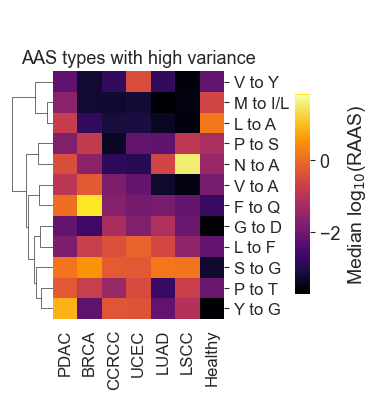

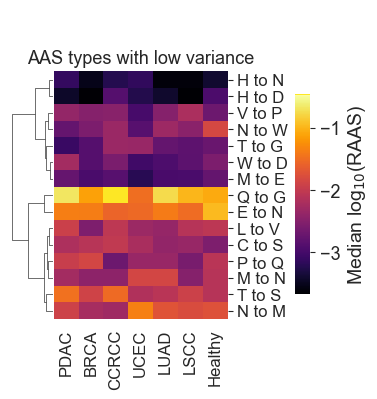

In [17]:
# plot heatmap of median RAAS for AAS types with high variance across datasets (Ext. Data Fig. 5e)

high_var_heatmap_df = heatmap_df.iloc[high_var_idx]
c = sns.clustermap(data=high_var_heatmap_df, figsize=(3,4), yticklabels=True, method='ward', xticklabels=True,
                   col_cluster=False, cmap=custom_cmap)
c.ax_heatmap.set_xticklabels(c.ax_heatmap.get_xmajorticklabels(), fontsize = 12)
c.ax_heatmap.set_yticklabels(c.ax_heatmap.get_ymajorticklabels(), fontsize = 12)
c.ax_heatmap.set_facecolor('#DDDDDD')
c.ax_cbar.set_ylabel(r'Median log$_{10}$(RAAS)')
c.ax_cbar.set_position([1,.25,0.05,0.5])
c.ax_cbar.yaxis.label.set_size(14)
c.ax_cbar.tick_params(labelsize=13)
c.ax_heatmap.set_title('AAS types with high variance', position=(0.5,0.5), fontsize=13)
c.savefig(outdir+'Reporter_highvar_heatmap_df_by_AAS_heatmap.pdf', bbox_inches='tight')

# plot heatmap of median RAAS for AAS types with low variance across datasets (Ext. Data Fig. 5d)

low_var_heatmap_df = heatmap_df.iloc[low_var_idx]
c = sns.clustermap(data=low_var_heatmap_df, figsize=(3,4), yticklabels=True, method='ward', xticklabels=True,
                   col_cluster=False, cmap=custom_cmap)
c.ax_heatmap.set_xticklabels(c.ax_heatmap.get_xmajorticklabels(), fontsize = 12)
c.ax_heatmap.set_yticklabels(c.ax_heatmap.get_ymajorticklabels(), fontsize = 12)
c.ax_heatmap.set_facecolor('#DDDDDD')
c.ax_cbar.set_ylabel(r'Median log$_{10}$(RAAS)')
c.ax_cbar.set_position([1,0.25,0.05,0.5])
c.ax_cbar.yaxis.label.set_size(14)
c.ax_cbar.tick_params(labelsize=13)
c.ax_heatmap.set_title('AAS types with low variance', position=(0.5,0.5), fontsize=13)
c.savefig(outdir+'Reporter_lowvar_heatmap_df_by_AAS_heatmap.pdf', bbox_inches='tight')

### Figure 4a: Ranked bar plot of median RAAS for AAS types, highlighting specific AAS types in violin plot, with barplot showing # SAAP detected for each AAS type

In [18]:
# add percentile stats for RAAS of each AAS type to Ratios_by_AAS dictionary 

pcntile_list = [90, 75, 25, 10, 'max', 'min']

for ds in datasets:
    print(ds)
    aas_ratio_df = ratios_by_aas[ds]['Precursor_ratio_df']
    aas_in_plot = list(set(aas_ratio_df['AAS'].values))
    
    for pcntile in pcntile_list:
        title_str = pcntile if isinstance(pcntile,str) else str(pcntile)+'percentile'
        if isinstance(pcntile,int):
            prec_percentiles = [np.percentile([x for x in aas_ratio_df.loc[aas_ratio_df['AAS']==aas,'RAAS'].values], pcntile) for aas in aas_in_plot]
        elif pcntile=='max':
            prec_percentiles = [np.max([x for x in aas_ratio_df.loc[aas_ratio_df['AAS']==aas,'RAAS'].values]) for aas in aas_in_plot]
        else:
            prec_percentiles = [np.min([x for x in aas_ratio_df.loc[aas_ratio_df['AAS']==aas,'RAAS'].values]) for aas in aas_in_plot]
        prec_sorted_idx = np.argsort(prec_percentiles)
        prec_sorted_percentiles = [prec_percentiles[i] for i in prec_sorted_idx]
        prec_sorted_subs = [aas_in_plot[i] for i in prec_sorted_idx]

        if ds !='Healthy':
            aas_ratio_df = ratios_by_aas[ds]['Reporter_ratio_df']
            if isinstance(pcntile,int):
                reporter_percentiles = [np.percentile([x for x in aas_ratio_df.loc[aas_ratio_df['AAS']==aas,'RAAS'].values], pcntile) for aas in aas_in_plot]
            elif pcntile=='max':
                reporter_percentiles = [np.max([x for x in aas_ratio_df.loc[aas_ratio_df['AAS']==aas,'RAAS'].values]) for aas in aas_in_plot]
            else:
                reporter_percentiles = [np.min([x for x in aas_ratio_df.loc[aas_ratio_df['AAS']==aas,'RAAS'].values]) for aas in aas_in_plot]
            reporter_sorted_idx = np.argsort(reporter_percentiles)
            reporter_sorted_percentiles = [reporter_percentiles[i] for i in reporter_sorted_idx]
            reporter_sorted_subs = [aas_in_plot[i] for i in reporter_sorted_idx]

            ratios_by_aas[ds]['Prec_AAS_'+str(title_str)+'_sorted']=prec_sorted_subs
            ratios_by_aas[ds]['Prec_'+str(title_str)+'_sorted']=prec_sorted_percentiles
            ratios_by_aas[ds]['Reporter_AAS_'+str(title_str)+'_sorted']=reporter_sorted_subs
            ratios_by_aas[ds]['Reporter_'+str(title_str)+'_sorted']=reporter_sorted_percentiles
        else:
            ratios_by_aas[ds]['Prec_AAS_'+str(title_str)+'_sorted']=prec_sorted_subs
            ratios_by_aas[ds]['Prec_'+str(title_str)+'_sorted']=prec_sorted_percentiles
            ratios_by_aas[ds]['Reporter_AAS_'+str(title_str)+'_sorted']=prec_sorted_subs
            ratios_by_aas[ds]['Reporter_'+str(title_str)+'_sorted']=prec_sorted_percentiles

# add the number of SAAP with each AAS type quantified across all datasets          
for ds in datasets:
    print(ds)
    ds_ratios = ratios_by_aas[ds]
    prec_aas = ds_ratios['Precursor_ratio_df']
    n_prec_aas = {aas:len(prec_aas.loc[prec_aas['AAS']==aas]) for aas in set(prec_aas['AAS'].values)}
    ds_ratios['Precursor_N_AAS'] = n_prec_aas
    if ds!='Healthy':
        reporter_aas = ds_ratios['Reporter_ratio_df']
        n_reporter_aas = {aas:len(reporter_aas.loc[reporter_aas['AAS']==aas]) for aas in set(reporter_aas['AAS'].values)}
        ds_ratios['Reporter_N_AAS'] = n_reporter_aas

pickle.dump(ratios_by_aas, open(outdir+'Ratios_by_AAS.p','wb'))

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy
CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


In [19]:
# create dataframe with values needed for plot (e.g. median RAAS, 90th percentile RAAS, for each AAS type)

plot_rows = []
plot_cols = ['Dataset','AAS type','Median Log$_{10}$ RAAS', '90th percentile Log$_{10}$ RAAS', 'Max Log$_{10}$ RAAS', 'RAAS type', 'N']

for ds in datasets:
    print(ds)
    ds_ratios = ratios_by_aas[ds]
    prec_aas = ds_ratios['prec_AAS_sorted']
    prec_medians = ds_ratios['prec_medians_sorted']
    
    prec_90th_aas_pcntile = ds_ratios['Prec_AAS_90percentile_sorted']
    prec_90th_pcntile = ds_ratios['Prec_90percentile_sorted']
    prec_10th_aas_pcntile = ds_ratios['Prec_AAS_10percentile_sorted']
    prec_10th_pcntile = ds_ratios['Prec_10percentile_sorted']
    prec_90th_pcntile = [prec_10th_pcntile[prec_10th_aas_pcntile.index(aas)] if prec_medians[i]<0 else prec_90th_pcntile[prec_90th_aas_pcntile.index(aas)] for i,aas in enumerate(prec_aas)]
    
    prec_aas_max= ds_ratios['Prec_AAS_max_sorted']
    prec_max = ds_ratios['Prec_max_sorted']
    prec_aas_min= ds_ratios['Prec_AAS_min_sorted']
    prec_min = ds_ratios['Prec_min_sorted']
    prec_max = [prec_min[prec_aas_min.index(aas)] if prec_medians[i]<0 else prec_max[prec_aas_max.index(aas)] for i,aas in enumerate(prec_aas)]
    prec_n = [ds_ratios['Precursor_N_AAS'][aas] for aas in prec_aas]
    for i in range(len(prec_aas)):
        plot_rows.append([ds,prec_aas[i],prec_medians[i], prec_90th_pcntile[i],prec_max[i], 'Precursor', prec_n[i]])
    
    if ds!='Healthy':
        reporter_aas = ds_ratios['AAS_sorted']
        reporter_medians = ds_ratios['medians_sorted']
        reporter_90th_aas_pcntile = ds_ratios['Reporter_AAS_90percentile_sorted']
        reporter_90th_pcntile = ds_ratios['Reporter_90percentile_sorted']   
        reporter_10th_aas_pcntile = ds_ratios['Reporter_AAS_10percentile_sorted']
        reporter_10th_pcntile = ds_ratios['Reporter_10percentile_sorted']
        reporter_medians = [reporter_medians[i] for i,x in enumerate(reporter_aas) if x in reporter_90th_aas_pcntile] 
        reporter_aas = [x for x in reporter_aas if x in reporter_90th_aas_pcntile]
        reporter_90th_pcntile = [reporter_10th_pcntile[reporter_10th_aas_pcntile.index(aas)] if reporter_medians[i]<0 else reporter_90th_pcntile[reporter_90th_aas_pcntile.index(aas)] for i,aas in enumerate(reporter_aas)]
        reporter_aas_max= ds_ratios['Reporter_AAS_max_sorted']
        reporter_max = ds_ratios['Reporter_max_sorted']
        reporter_aas_min= ds_ratios['Reporter_AAS_min_sorted']
        reporter_min = ds_ratios['Reporter_min_sorted']
        reporter_max = [reporter_min[reporter_aas_min.index(aas)] if reporter_medians[i]<0 else reporter_max[reporter_aas_max.index(aas)] for i,aas in enumerate(reporter_aas)]
        reporter_n = [ds_ratios['Reporter_N_AAS'][aas] for aas in reporter_aas]
        for i in range(len(reporter_aas)):
            plot_rows.append([ds,reporter_aas[i],reporter_medians[i], reporter_90th_pcntile[i],reporter_max[i], 'Reporter', reporter_n[i]])

all_plot_df = pd.DataFrame(plot_rows,columns=plot_cols)
all_plot_df.to_excel(outdir+'RAAS_by_AAS_summary_stats_allDS.xlsx')


# collapse to get data for all datasets together

set_aas = list(set(all_plot_df['AAS type'].to_list()))
all_ds_plot_rows = []
plot_cols = ['AAS type','Median Log$_{10}$ RAAS', '90th percentile Log$_{10}$ RAAS','Max Log$_{10}$ RAAS', 'N']+['N '+ds for ds in datasets]
for aas in set_aas:
    aas_df = all_plot_df.loc[all_plot_df['AAS type']==aas]
    aas_df = aas_df.loc[((aas_df['Dataset']!='Healthy') & (aas_df['RAAS type']=='Reporter')) | (aas_df['Dataset']=='Healthy')]
    med = aas_df['Median Log$_{10}$ RAAS'].median()
    if med < 0:
        pcnt90 = min(aas_df['90th percentile Log$_{10}$ RAAS'])
    else:
        pcnt90 = np.max(aas_df['90th percentile Log$_{10}$ RAAS'])
    if med < 0:
        raas_max = min(aas_df['Max Log$_{10}$ RAAS'])
    else:
        raas_max = np.max(aas_df['Max Log$_{10}$ RAAS'])
    n = aas_df['N'].sum()
    ccrcc_n = aas_df.loc[aas_df['Dataset']=='CCRCC']
    if len(ccrcc_n)>0:
        ccrcc_n = ccrcc_n['N'].values[0]
    else:
        ccrcc_n = 0
    brca_n = aas_df.loc[aas_df['Dataset']=='BRCA']
    if len(brca_n)>0:
        brca_n = brca_n['N'].values[0]
    else:
        brca_n = 0
    ucec_n = aas_df.loc[aas_df['Dataset']=='UCEC']
    if len(ucec_n)>0:
        ucec_n = ucec_n['N'].values[0]
    else:
        ucec_n = 0
    luad_n = aas_df.loc[aas_df['Dataset']=='LUAD']
    if len(luad_n)>0:
        luad_n = luad_n['N'].values[0]
    else:
        luad_n = 0
    pdac_n = aas_df.loc[aas_df['Dataset']=='PDAC']
    if len(pdac_n)>0:
        pdac_n = pdac_n['N'].values[0]
    else:
        pdac_n = 0
    lscc_n = aas_df.loc[aas_df['Dataset']=='LSCC']
    if len(lscc_n)>0:
        lscc_n = lscc_n['N'].values[0]
    else:
        lscc_n = 0
    healthy_n = aas_df.loc[aas_df['Dataset']=='Healthy']
    if len(healthy_n)>0:
        healthy_n = healthy_n['N'].values[0]
    else:
        healthy_n = 0
    all_ds_plot_rows.append([aas, med, pcnt90, raas_max, n, ccrcc_n, ucec_n, brca_n, luad_n, pdac_n, lscc_n, healthy_n])

all_ds_plot_df = pd.DataFrame(all_ds_plot_rows, columns=plot_cols)
all_ds_plot_df.to_excel(outdir+'Reporter_RAAS_by_AAS_data_for_allDS_plot.xlsx')

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


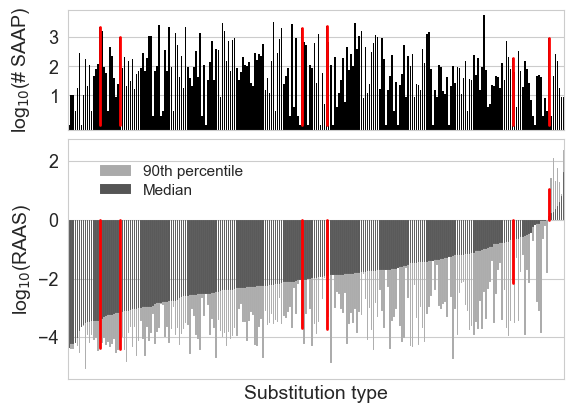

In [20]:
# plot barplots with # SAAP with each AAS and median/90th percentile RAAS for each AAS type 

# these AAS are highlighted with red lines and in the volcano plot
aas2plot= ['H to Q', 'H to D', 'E to D', 'T to S', 'L to M', 'S to G']

plot_df = all_ds_plot_df
subs_in_plot = list(set(plot_df['AAS type']))
medians = [np.mean([x for x in plot_df.loc[plot_df['AAS type']==sub,'Median Log$_{10}$ RAAS'].values]) for sub in subs_in_plot]
sorted_idx = np.argsort(medians)
sorted_medians = [medians[i] for i in sorted_idx]
sorted_subs = [subs_in_plot[i] for i in sorted_idx]

sns.set_style('whitegrid')
f = plt.figure()
gs = gridspec.GridSpec(2,1,height_ratios=[1,2], hspace=0.05)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

sns.barplot(data=plot_df,x='AAS type', y='90th percentile Log$_{10}$ RAAS', color='#aaaaaa', order=sorted_subs, linewidth=0.05, errorbar=None, ax=ax1, label='90th percentile')#, errwidth=0.1)
sns.barplot(data=plot_df,x='AAS type', y='Median Log$_{10}$ RAAS', color='#555555', order=sorted_subs, linewidth=0.05, errorbar=None, ax=ax1, label='Median')#, errwidth=0.1)
ax1.set_xticks([]);
ax1.set_ylabel(r'log$_{10}$(RAAS)', fontsize=14)
ax1.set_xlabel('Substitution type', fontsize=14)
ax1.tick_params('y', labelsize=13)

sns.barplot(data=plot_df,x='AAS type', y='N', color='black', order=sorted_subs, linewidth=0.0, errorbar=None, ax=ax0)#, errwidth=0.1)
for aas in aas2plot:
    aas_df = plot_df.loc[plot_df['AAS type']==aas]
    max_raas = aas_df['90th percentile Log$_{10}$ RAAS'].values[0]
    n = aas_df['N'].values[0]
    idx = sorted_subs.index(aas)
    plt.plot((idx,idx), (max_raas, 0), '-r', linewidth=2)
    ax0.plot((idx,idx), (1, n), '-r', linewidth=2)

ax0.set_xticks([]);
ax0.set_xlabel('')
ax0.set_yscale('log')#, basey=2)
ax0.grid(which='major', visible=True)
#ax0.set_title(ds, fontsize=14)
ax0.set_ylabel('log$_{10}$(# SAAP)', fontsize=14, labelpad=12)
ax0.set_yticks([10,100, 1000])
ax0.set_yticklabels(['1','2','3'])
ax1.set_yticks([-4,-2,0, 2])
ax0.tick_params('y',labelsize=13)
ax1.legend(bbox_to_anchor=(0.38,0.95), fontsize=11, frameon=False, labelspacing=0.3)#, loc='upper left')
ax1.yaxis.set_major_locator(FixedLocator([-6,-4,-2,0, 2]))
ax0.margins(x=0)
ax1.margins(x=0)
plt.savefig(outdir+'All_data_reporterRAAS_by_AAS_mean_90th_barplot.pdf', bbox_inches='tight')

H to Q
H to D
E to D
T to S
L to M
S to G


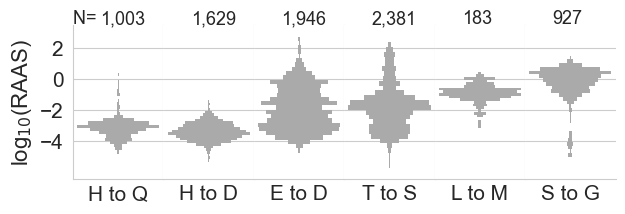

In [21]:
# plot the volcano plot highlighting AAS with large N across range of RAAS distributions

fig,axes = plt.subplots(1, len(aas2plot), figsize=(7,2), sharey=True)
plt.subplots_adjust(wspace=0)
sns.set_style('whitegrid')

quant_df = filt_reporter_quant_df
for i,aas in enumerate(aas2plot):
    print(aas)
    ax = axes[i]
    ax.set_xlabel(aas, fontsize=15)
    ax.set_xticks([])    
    aas_raas_data = quant_df.loc[quant_df['AAS']==aas, 'RAAS'].values
    aas_raas_data = [x for x in aas_raas_data if ~np.isnan(x) and ~np.isinf(x)]
    
    bihist(aas_raas_data, aas_raas_data, nbins=30, h=ax)
    if i>0:
        ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if ax==axes[-1]:
        ax.spines['right'].set_visible(False)
    if ax==axes[0]:
        ax.annotate('N= ', (0,1.01), xycoords='axes fraction', fontsize=13)
    ax.annotate('{:,}'.format((len(aas_raas_data))), (0.3,1.01), xycoords='axes fraction', fontsize=13)
axes[0].set_yticks([-4,-2,0,2])
axes[0].set_ylabel(r'log$_{10}$(RAAS)', fontsize=16)
axes[0].tick_params('y', labelsize=15)
plt.savefig(outdir+'All_DS_example_AAStype_RAASdistributions_bihist.pdf', bbox_inches='tight')    

### Extended Data Figure 5g: Median RAAS for Encoded and Incoporated AAS types correlations across datasets

In [22]:
# add median precursor and reporter ion RAAS across all peptides identified with each base (encoded) or incorporated AA to ratios_by_aas dictionary

aa_list = sorted(list(set(x[0] for x in AASs)))

# add median precursor RAAS across all peptides with each base AA
for ds in datasets: 
    print(ds)
    aa_ratio_rows = []
    aa_ratio_cols = ['Base AA', 'RAAS']
    ds_ratio_df = ratios_by_aas[ds]['Precursor_ratio_df']
    for aa in aa_list:
        aa_idx = [i for i,row in ds_ratio_df.iterrows() if row['AAS'][0]==aa]
        if len(aa_idx)>0:
            aa_df = ds_ratio_df.loc[aa_idx]
            for j, row in aa_df.iterrows():
                aa_ratio_rows.append([aa, row['RAAS']])
    ds_aa_df = pd.DataFrame(aa_ratio_rows, columns = aa_ratio_cols)  
    aa_medians = [np.nanmedian([x for x in ds_aa_df.loc[ds_aa_df['Base AA']==aa,'RAAS'].values]) for aa in aa_list]
    aa_sorted_idx = np.argsort(aa_medians)
    aa_sorted_medians = [aa_medians[i] for i in aa_sorted_idx]
    aa_sorted_subs = [aa_list[i] for i in aa_sorted_idx]
    ratios_by_aas[ds]['Base_prec_AA_RAAS_df'] = ds_aa_df
    ratios_by_aas[ds]['Base_prec_AAS_sorted'] = aa_sorted_subs
    ratios_by_aas[ds]['Base_prec_medians_sorted'] = aa_sorted_medians

# add median reporter RAAS across all peptides with each base AA
for ds in datasets: 
    print(ds)
    if ds!='Healthy':
        aa_ratio_rows = []
        aa_ratio_cols = ['Base AA', 'RAAS']
        ds_ratio_df = ratios_by_aas[ds]['Reporter_ratio_df']
        for aa in aa_list:
            aa_idx = [i for i,row in ds_ratio_df.iterrows() if row['AAS'][0]==aa]
            if len(aa_idx)>0:
                aa_df = ds_ratio_df.loc[aa_idx]
                for j, row in aa_df.iterrows():
                    aa_ratio_rows.append([aa, row['RAAS']])
        ds_aa_df = pd.DataFrame(aa_ratio_rows, columns = aa_ratio_cols)  
        aa_medians = [np.nanmedian([x for x in ds_aa_df.loc[ds_aa_df['Base AA']==aa,'RAAS'].values]) for aa in aa_list]
        aa_sorted_idx = np.argsort(aa_medians)
        aa_sorted_medians = [aa_medians[i] for i in aa_sorted_idx]
        aa_sorted_subs = [aa_list[i] for i in aa_sorted_idx]
        ratios_by_aas[ds]['Base_reporter_AA_RAAS_df'] = ds_aa_df
        ratios_by_aas[ds]['Base_reporter_AAS_sorted'] = aa_sorted_subs
        ratios_by_aas[ds]['Base_reporter_medians_sorted'] = aa_sorted_medians
        
# add median precursor RAAS across all peptides with each susbtituted/destination AA  
for ds in datasets: 
    print(ds)
    aa_ratio_rows = []
    aa_ratio_cols = ['Sub AA', 'RAAS']
    ds_ratio_df = ratios_by_aas[ds]['Precursor_ratio_df']
    for aa in aa_list:
        aa_idx = [i for i,row in ds_ratio_df.iterrows() if row['AAS'][-1]==aa]
        if len(aa_idx)>0:
            aa_df = ds_ratio_df.loc[aa_idx]
            for j, row in aa_df.iterrows():
                aa_ratio_rows.append([aa, row['RAAS']])
    ds_aa_df = pd.DataFrame(aa_ratio_rows, columns = aa_ratio_cols)  
    aa_medians = [np.nanmedian([x for x in ds_aa_df.loc[ds_aa_df['Sub AA']==aa,'RAAS'].values]) for aa in aa_list]
    aa_sorted_idx = np.argsort(aa_medians)
    aa_sorted_medians = [aa_medians[i] for i in aa_sorted_idx]
    aa_sorted_subs = [aa_list[i] for i in aa_sorted_idx]
    ratios_by_aas[ds]['Sub_AA_RAAS_df'] = ds_aa_df
    ratios_by_aas[ds]['Sub_AAS_sorted'] = aa_sorted_subs
    ratios_by_aas[ds]['Sub_medians_sorted'] = aa_sorted_medians

# add median reporter RAAS across all peptides with each susbtituted/destination AA  
for ds in datasets: 
    print(ds)
    if ds!='Healthy':
        aa_ratio_rows = []
        aa_ratio_cols = ['Sub AA', 'RAAS']
        ds_ratio_df = ratios_by_aas[ds]['Reporter_ratio_df']
        for aa in aa_list:
            aa_idx = [i for i,row in ds_ratio_df.iterrows() if row['AAS'][-1]==aa]
            if len(aa_idx)>0:
                aa_df = ds_ratio_df.loc[aa_idx]
                for j, row in aa_df.iterrows():
                    aa_ratio_rows.append([aa, row['RAAS']])
        ds_aa_df = pd.DataFrame(aa_ratio_rows, columns = aa_ratio_cols)  
        aa_medians = [np.nanmedian([x for x in ds_aa_df.loc[ds_aa_df['Sub AA']==aa,'RAAS'].values]) for aa in aa_list]
        aa_sorted_idx = np.argsort(aa_medians)
        aa_sorted_medians = [aa_medians[i] for i in aa_sorted_idx]
        aa_sorted_subs = [aa_list[i] for i in aa_sorted_idx]
        ratios_by_aas[ds]['Sub_reporter_AA_RAAS_df'] = ds_aa_df
        ratios_by_aas[ds]['Sub_reporter_AAS_sorted'] = aa_sorted_subs
        ratios_by_aas[ds]['Sub_reporter_medians_sorted'] = aa_sorted_medians
    
pickle.dump(ratios_by_aas, open(outdir+'Ratios_by_AAS.p', 'wb'))

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy
CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy
CCRCC


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


UCEC
BRCA


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


LUAD


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


PDAC


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


LSCC


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Healthy


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


CCRCC


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


UCEC


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


BRCA


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


LUAD


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


PDAC


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


LSCC
Healthy


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_81894/972846376.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.ax_cbar.set_yticklabels([0,0.2,0.4,0.6,0.8, 1], fontsize=13)


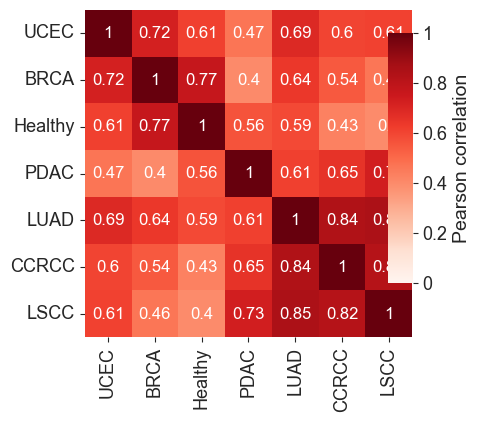

In [23]:
# generate heatmap dataframe that will be used to compute correlations of Base AA RAAS across datasets
heatmap_data = pd.DataFrame(index=aa_list, columns=datasets)
for i, row in heatmap_data.iterrows():
    for ds in datasets:
       # if ds!='Healthy':
       #     medians = ratios_by_aas[ds]['Base_reporter_medians_sorted']
       #     aas = ratios_by_aas[ds]['Base_reporter_AAS_sorted']
       # else:
        medians = ratios_by_aas[ds]['Base_prec_medians_sorted']
        aas = ratios_by_aas[ds]['Base_prec_AAS_sorted']
        for i,aa in enumerate(aa_list):
            heatmap_data.loc[aa,ds] = medians[aas.index(aa)]
heatmap_df = heatmap_data
heatmap_df.dropna(how='any', axis=0, inplace=True)
heatmap_df = heatmap_df.astype(float)
medians = [np.median(row.values) for i,row in heatmap_df.iterrows()]
rank_order = np.argsort(medians)
aa_sorted = [heatmap_df.index.to_list()[i] for i in rank_order]
heatmap_df = heatmap_df.loc[aa_sorted]
                        
# compute correlations of vectors of Base AA median RAAS across datasets 
heatmap_df_4corr = heatmap_df.dropna(how='any')
corr_heatmap = pd.DataFrame(index=datasets, columns=datasets)
for ds1 in datasets:
    for ds2 in datasets:
        corr = sp.stats.pearsonr(heatmap_df_4corr[ds1].values, heatmap_df_4corr[ds2].values)[0]
        corr_heatmap.loc[ds1,ds2] = corr
corr_heatmap = corr_heatmap.astype(float)

# plot the correlation heatmap for base AA RAAS across datasets 
s= sns.clustermap(corr_heatmap, figsize=(5,5), annot=np.round(corr_heatmap, 2), cmap='Reds', cbar_kws={'label':'Pearson correlation', 'pad':1}, annot_kws={"fontsize":12},
                 vmax=1, vmin=0, row_cluster=True, col_cluster=True)

s.ax_heatmap.tick_params(right=False, left=True, labelright=False, labelleft=True, labelbottom=True, bottom=True)
plt.setp(s.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, fontsize=13)
plt.setp(s.ax_heatmap.yaxis.get_majorticklabels(), fontsize=13)
s.ax_cbar.set_position([0.8,0.26,0.05,0.5])
s.ax_cbar.yaxis.label.set_size(14)
s.ax_cbar.set_yticklabels([0,0.2,0.4,0.6,0.8, 1], fontsize=13)
s.ax_row_dendrogram.set_visible(False)
s.ax_col_dendrogram.set_visible(False)
plt.savefig(outdir+'Correlation_heatmap_BaseAA_precursorRatios.pdf', bbox_inches='tight')

/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_81894/350640123.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.ax_cbar.set_yticklabels([0,0.2,0.4,0.6,0.8, 1], fontsize=13)


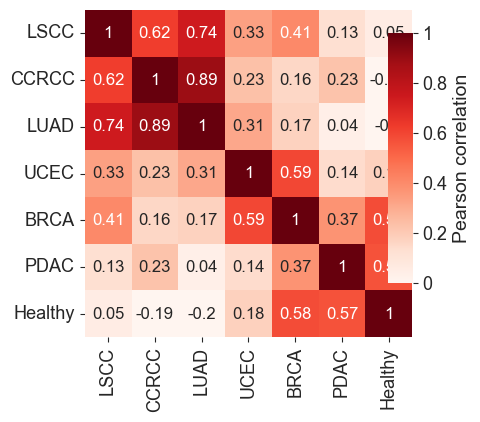

In [24]:
# generate heatmap dataframe that will be used to compute correlations of substituted AA RAAS across datasets
heatmap_data = pd.DataFrame(index=aa_list, columns=datasets)
for i, row in heatmap_data.iterrows():
    for ds in datasets:
        #if ds!='Healthy':
        #    medians = ratios_by_aas[ds]['Sub_reporter_medians_sorted']
        #    aas = ratios_by_aas[ds]['Sub_reporter_AAS_sorted']
        #else:
        medians = ratios_by_aas[ds]['Sub_medians_sorted']
        aas = ratios_by_aas[ds]['Sub_AAS_sorted']
        for i,aa in enumerate(aa_list):
            heatmap_data.loc[aa,ds] = medians[aas.index(aa)]
heatmap_df = heatmap_data
heatmap_df.dropna(how='any', axis=0, inplace=True)
heatmap_df = heatmap_df.astype(float)
medians = [np.median(row.values) for i,row in heatmap_df.iterrows()]
rank_order = np.argsort(medians)
aa_sorted = [heatmap_df.index.to_list()[i] for i in rank_order]
heatmap_df = heatmap_df.loc[aa_sorted]


# compute correlations of vectors of Substituted AA median RAAS across datasets 
heatmap_df_4corr = heatmap_df.dropna(how='any')
corr_heatmap = pd.DataFrame(index=datasets, columns=datasets)
for ds1 in datasets:
    for ds2 in datasets:
        corr = sp.stats.pearsonr(heatmap_df_4corr[ds1].values, heatmap_df_4corr[ds2].values)[0]
        corr_heatmap.loc[ds1,ds2] = corr
corr_heatmap = corr_heatmap.astype(float)

# plot the correlation heatmap for substituted AA RAAS across datasets 
s= sns.clustermap(corr_heatmap, figsize=(5,5), annot=np.round(corr_heatmap, 2), cmap='Reds', cbar_kws={'label':'Pearson correlation', 'pad':1}, annot_kws={"fontsize":12},
                 vmax=1, vmin=0, row_cluster=True, col_cluster=True)

s.ax_heatmap.tick_params(right=False, left=True, labelright=False, labelleft=True, labelbottom=True, bottom=True)
plt.setp(s.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, fontsize=13)
plt.setp(s.ax_heatmap.yaxis.get_majorticklabels(), fontsize=13)
s.ax_cbar.set_position([0.8,0.26,0.05,0.5])
s.ax_cbar.yaxis.label.set_size(14)
s.ax_cbar.set_yticklabels([0,0.2,0.4,0.6,0.8, 1], fontsize=13)
s.ax_row_dendrogram.set_visible(False)
s.ax_col_dendrogram.set_visible(False)
plt.savefig(outdir+'Correlation_heatmap_SubstitutedAA_precursorRatios.pdf', bbox_inches='tight')

### Figure 4f: ANOVA of RAAS variance by data type, AAS type, tissue type

In [ ]:
# get dataframe for ANOVA analysis

# list of tissues each CPTAC dataset represents, in same order as dataset_list 
cptac_tissue_list = ['kidney', 'endometrium', 'breast', 'lung', 'pancreas', 'lung']


anova_rows = []
anova_cols = ['SAAP', 'BP', 'AAS', 'RAAS', 'Tissue', 'Dataset', 'Data_type'] # data type will be TMT or label-free
for i,row in filt_reporter_quant_df.iterrows():
    ds = row['Dataset']
    anova_rows.append([row['SAAP'], row['BP'], row['AAS'], row['RAAS'], cptac_tissue_list[datasets.index(ds)], ds, 'TMT-labeled'])
    
healthy_df = filt_prec_quant_df.loc[filt_prec_quant_df['Dataset']=='Healthy']
for i,row in healthy_df.iterrows():
    anova_rows.append([row['SAAP'], row['BP'], row['AAS'], row['RAAS'], row['TMT/Tissue'], 'Healthy', 'Label-free'])

anova_df = pd.DataFrame(anova_rows, columns=anova_cols)
anova_df.replace(np.inf, np.nan, inplace=True)
anova_df.replace(-np.inf, np.nan, inplace=True)
anova_df.dropna(how='any', inplace=True)

anova_df['Encoded'] = [x.split(' to ')[0] for x in anova_df.AAS.to_list()]
anova_df['Incorporated'] = [x.split(' to ')[1] for x in anova_df.AAS.to_list()]
anova_df.to_excel(outdir+'ANOVA_AAS_tissue_df.xlsx')

In [30]:
anova_df = pd.read_excel(dependencies_dir+'ANOVA_AAS_tissue_df.xlsx')

In [35]:
model = ols('RAAS ~ C(AAS) + C(Encoded) + C(Incorporated) + C(Tissue) + C(Data_type)', data=anova_df).fit()
df = sm.stats.anova_lm(model, typ=3)
df.reset_index(inplace=True)
df.columns = ['Variable']+df.columns.to_list()[1:]

# plot results
plot_df = df.loc[1:5, ['Variable', 'F', 'PR(>F)']]
plot_df = df.loc[1:5, ['Variable', 'F', 'PR(>F)']]
plot_df['PR(>F)'] = ['{:.2e}'.format(x) for x in plot_df['PR(>F)']]

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 248, but rank is 32
  warnings.warn('covariance of constraints does not have full '


In [36]:
plot_df

,Variable,F,PR(>F)
1,C(AAS),1.350737,8.90e-02
2,C(Encoded),1.113119,3.33e-01
3,C(Incorporated),1.874500,1.81e-02
4,C(Tissue),76.788554,0.00e+00
5,C(Data_type),32.921380,9.63e-09


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 248, but rank is 32
  warnings.warn('covariance of constraints does not have full '


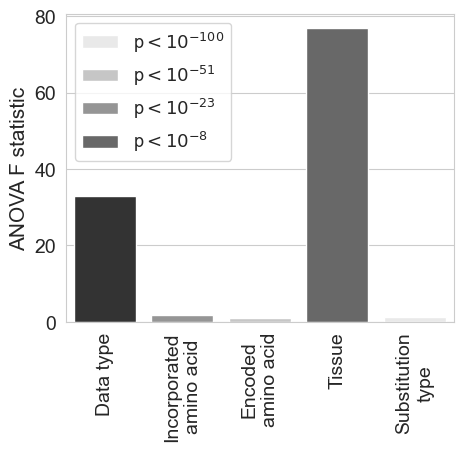

In [31]:
# generate ordinary least squares model with variables of interest (tissue type, data type, AAS type, etc)
model = ols('RAAS ~ C(AAS) + C(Encoded) + C(Incorporated) + C(Tissue) + C(Data_type)', data=anova_df).fit()
df = sm.stats.anova_lm(model, typ=3)
df.reset_index(inplace=True)
df.columns = ['Variable']+df.columns.to_list()[1:]

# plot results
plot_df = df.loc[1:5, ['Variable', 'F', 'PR(>F)']]
plot_df = df.loc[1:5, ['Variable', 'F', 'PR(>F)']]
plot_df['PR(>F)'] = ['{:.2e}'.format(x) for x in plot_df['PR(>F)']]
plot_df['Variable'] = ['Substitution\ntype', 'Encoded\namino acid', 'Incorporated\namino acid', 'Tissue', 'Data type']

sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(5,4))
sns.barplot(data=plot_df, x='Variable', y='F', hue='PR(>F)', dodge=False, palette='Greys',
           order=['Data type', 'Incorporated\namino acid', 'Encoded\namino acid', 'Tissue','Substitution\ntype'])
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=['p$<10^{-100}$', 'p$<10^{-51}$', 'p$<10^{-23}$', 'p$<10^{-8}$'], loc='upper left', fontsize=13)
plt.xlabel('')
plt.ylabel('ANOVA F statistic', fontsize=15)
ax.tick_params('both', labelsize=14)
ax.tick_params('x', rotation=90)
plt.savefig(outdir+'ANOVA_tissue_AAS_results_extended.pdf', bbox_inches='tight')

### Extended Data Figure 5h,i:  AAS type enrichment in tissue types

In [37]:
# set of all AAS types
aas_list = list(set(filt_saap_df['AAS'].to_list()))

# get index of rows in precursor quant data (Extended_Data_2) corresponding to tissue types represented by CPTAC and healthy datasets 
kidney_rows = [i for i,row in filt_prec_quant_df.iterrows() if row['Dataset']=='CCRCC' or row['TMT/Tissue']=='kidney']
lung_rows = [i for i,row in filt_prec_quant_df.iterrows() if row['Dataset']=='LUAD' or row['Dataset']=='LSCC' or row['TMT/Tissue']=='lung']
pancreas_rows = [i for i,row in filt_prec_quant_df.iterrows() if row['Dataset']=='PDAC' or row['TMT/Tissue']=='pancreas']
endometrium_rows = [i for i,row in filt_prec_quant_df.iterrows() if row['Dataset']=='UCEC' or row['TMT/Tissue']=='endometrium']


def get_aas_fc_alt(aas, tissue_rows):
    """
    Function to get the log2 fold change and pvalue between RAAS for peptides with an AAS type in a given tissue vs RAAS for peptides with that AAS type in all other tissues
    Input: AAS type, index in precursor quant df of tissues of interest (extracted above)
    Output: Log2FC and Pvalue of RAAS comparison for AAS across tissues
    Requires at least 10 peptides with AAS in tissue type and other tissue types for comparison
    """
    tissue_df = filt_prec_quant_df.loc[tissue_rows]
    tissue_raas = [x for x in tissue_df.loc[tissue_df['AAS']==aas, 'RAAS'].to_list() if ~np.isnan(x) and ~np.isinf(x)]
    other_rows = [i for i in filt_prec_quant_df.index if i not in tissue_rows]
    other_df = filt_prec_quant_df.loc[other_rows]
    other_raas = [x for x in other_df.loc[other_df['AAS']==aas, 'RAAS'].to_list() if ~np.isnan(x) and ~np.isinf(x)]   
    if len(tissue_raas)>10 and len(other_raas)>10:
        l2fc = np.log2(10**(np.mean(tissue_raas)-np.mean(other_raas)))
        pval = sp.stats.ttest_ind(tissue_raas, other_raas)[1]
    else:
        l2fc = np.nan
        pval = np.nan
    return(l2fc, pval)

# get dataframe with fold change and pvalues for AAS type RAAS in given tissue vs all other tissues 
aas_fc_rows = []
aas_fc_cols = ['AAS', 'Tissue', 'RAAS FC', 'pvalue']
for aas in aas_list:
    kidney_fc, kidney_pval = get_aas_fc_alt(aas, kidney_rows)
    lung_fc, lung_pval = get_aas_fc_alt(aas, lung_rows)
    pancreas_fc, pancreas_pval = get_aas_fc_alt(aas, pancreas_rows)
    endometrium_fc, endometrium_pval = get_aas_fc_alt(aas, endometrium_rows)
    aas_fc_rows.append([aas, 'Kidney', kidney_fc, kidney_pval])
    aas_fc_rows.append([aas, 'Lung', lung_fc, lung_pval])
    aas_fc_rows.append([aas, 'Pancreas', pancreas_fc, pancreas_pval])
    aas_fc_rows.append([aas, 'Endometrium', endometrium_fc, endometrium_pval])
aas_fc_df_alt = pd.DataFrame(aas_fc_rows, columns=aas_fc_cols)
aas_fc_df_alt.dropna(how='any', axis=0, inplace=True)

# adjust pvalues for multiple testing
aas_fc_df_alt['padj'] = multipletests(aas_fc_df_alt['pvalue'].to_list(), method='fdr_bh')[1]
aas_fc_df_alt['-log q'] = [-1*np.log10(x) for x in aas_fc_df_alt['padj']]
aas_fc_df_alt['Significant'] = ['Significant' if row['padj']<=0.01 and np.abs(row['RAAS FC']>=1) else 'Not significant' for i,row in aas_fc_df_alt.iterrows()]
aas_fc_df_alt['Hue'] = [row['Tissue'] if row['Significant']=='Significant' else 'Not significant' for i,row in aas_fc_df_alt.iterrows()]

aas_fc_df_alt.to_excel(outdir+'AAS_RAAS_tissue_FC_n10.xlsx')

/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_81894/3962106052.py:5: UserWarning: The palette list has more values (11) than needed (5), which may not be intended.
  sns.scatterplot(data=aas_fc_df_alt, y='-log q', x='RAAS FC', hue='Hue', palette=['#aaaaaa']+colors)
Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


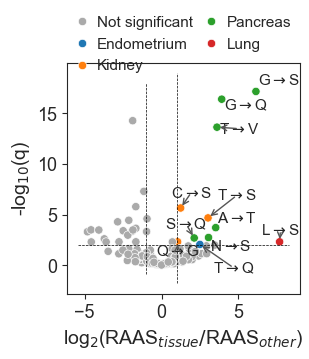

In [38]:
# plot volcano plot of tissue type RAAS significance for AAS types (Ext. Data Fig. 5h)

sns.set_style('ticks')
fig,ax = plt.subplots(figsize=(3,3))
sns.scatterplot(data=aas_fc_df_alt, y='-log q', x='RAAS FC', hue='Hue', palette=['#aaaaaa']+colors)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title='', fontsize=11, handletextpad=0, bbox_to_anchor=(0.48,1.08), ncol=2, frameon=False, loc='center', columnspacing=0.2)

plt.ylabel('-log$_{10}$(q)', fontsize=14)
plt.xlabel('log$_{2}$(RAAS$_{tissue}/$RAAS$_{other}$)', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.plot((-1,-1), ax.get_ylim(), '--k' , linewidth=0.5)
plt.plot((1,1), ax.get_ylim(), '--k' , linewidth=0.5)
plt.plot(ax.get_xlim(), (2,2), '--k' , linewidth=0.5)

sig_df = aas_fc_df_alt.loc[aas_fc_df_alt['Significant']=='Significant']
texts = []
for i,row in sig_df.iterrows():
    x=row['RAAS FC']
    y=row['-log q']
    s=row['AAS'][0]+r'$\rightarrow$'+row['AAS'][-1]
    if x>0:
        texts.append(ax.text(x,y,s,fontsize=11))
adjust_text(texts, expand_points=(1,1), expand_text=(1,2), ax=fig.axes[0],
            arrowprops=dict(arrowstyle='->', color='#555555', lw=1), force_text=0.3)

plt.savefig(outdir+'Tissue_AAS_highRAAS_volcano.pdf', bbox_inches='tight')

T to Q Endometrium
Q to G Kidney
T to S Kidney
C to S Kidney
L to S Lung
N to S Pancreas
S to Q Pancreas
T to V Pancreas
G to Q Pancreas
A to T Pancreas
G to S Pancreas


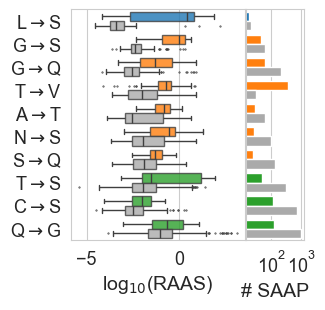

In [53]:
# create dataframe with RAAS values and number of peptides for AAS types with significantly high RAAS in given tissue

plot_rows = []
plot_cols = ['Tissue', 'RAAS', 'Type', 'N', 'AAS']
sig_df = aas_fc_df_alt.loc[aas_fc_df_alt['Significant']=='Significant']
sig_df = sig_df.loc[sig_df['RAAS FC']>0]
sig_df.sort_values('Tissue', inplace=True)
for i,row in sig_df.iterrows():
    aas = row['AAS']
    aas_str = aas[0]+r'$\rightarrow$'+aas[-1]
    tissue = row['Tissue']
    print(aas, tissue)
    if tissue == 'Kidney':
        tissue_rows = kidney_rows
    elif tissue =='Lung':
        tissue_rows = lung_rows
    elif tissue == 'Pancreas':
        tissue_rows = pancreas_rows
    elif tissue == 'Endometrium':
        tissue_rows = endometrium_rows
    tissue_df = filt_prec_quant_df.loc[tissue_rows]
    tissue_raas = [x for x in tissue_df.loc[tissue_df['AAS']==aas, 'RAAS'].to_list() if ~np.isnan(x) and ~np.isinf(x)]
    n_tissue = len(tissue_raas)
    other_rows = [i for i in filt_prec_quant_df.index if i not in tissue_rows]
    other_df = filt_prec_quant_df.loc[other_rows]
    other_raas = [x for x in other_df.loc[other_df['AAS']==aas, 'RAAS'].to_list() if ~np.isnan(x) and ~np.isinf(x)]   
    n_other = len(other_raas)
    for raas in tissue_raas:
        plot_rows.append([tissue, raas, 'Significant tissue', n_tissue, aas_str])#+'\n'+tissue])
    for raas in other_raas:
        plot_rows.append([tissue, raas, 'Other tissues', n_other, aas_str])#+'\n'+tissue])

plot_df = pd.DataFrame(plot_rows, columns=plot_cols)
order = [r'L$\rightarrow$S', r'G$\rightarrow$S', r'G$\rightarrow$Q', r'T$\rightarrow$V', r'A$\rightarrow$T', r'N$\rightarrow$S',r'S$\rightarrow$Q', r'T$\rightarrow$S',  r'C$\rightarrow$S', r'Q$\rightarrow$G']


# plot boxplots of RAAS distributions for AAS types with significantly high RAAS in a specific tissue (Ext. Data Fig. 5i)
# plot barplot of number of SAAP with AAS type in specific tissue and all other tissues 
sns.set_style('whitegrid')
fig,axes = plt.subplots(1,2,figsize=(3,3), gridspec_kw={'width_ratios':[3,1]}, sharey=True)
plt.subplots_adjust(wspace=0.01)
bx = sns.boxplot(data=plot_df, y='AAS', x='RAAS', hue='Type', palette=[colors[0], '#AAAAAA'], 
                 fliersize=0.5, linewidth=1, ax=axes[0], order=order)
axes[0].tick_params('both', labelsize=13)
axes[0].legend().remove()
axes[0].set_ylabel('')
axes[0].set_xlabel('log$_{10}$(RAAS)', fontsize=14)

br = sns.barplot(data=plot_df, y='AAS', x='N', hue='Type', palette=[colors[0], '#AAAAAA'], ax=axes[1], order=order)
axes[1].legend().remove()
axes[1].tick_params('both', labelsize=13)
axes[1].set_ylabel('')
axes[1].set_xscale('log')
axes[1].set_xlabel('# SAAP', fontsize=14)

g = '#AAAAAA'

custom_colors = [colors[0]]+[colors[1]]*6+[colors[2]]*3+[g]*10
for i, patch in enumerate(bx.patches):
    patch.set_facecolor(custom_colors[i % len(custom_colors)])
    patch.set_alpha(0.8)


custom_br_colors = [colors[0]]+[colors[1]]*6+[colors[2]]*3+[g]*10
for i, patch in enumerate(br.patches):
    patch.set_facecolor(custom_br_colors[i % len(custom_colors)])
    patch.set_alpha(1)

plt.savefig(outdir+'Sig_tissue_AAS_highRAAS_boxplots_orderedbyFC.pdf', bbox_inches='tight')